### Imports

In [1]:
from pathlib import Path
import torch
from loguru import logger

### Check device

In [2]:
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
logger.info(f"Device: {device}")

2025-12-29 11:58:16.239 | INFO     | __main__:<module>:8 - Device: cuda


### Laad de Flowers factory

In [3]:
from mads_datasets import DatasetFactoryProvider, DatasetType

flowersfactory = DatasetFactoryProvider.create_factory(DatasetType.FLOWERS)

### Bekijk de settings

In [4]:
flowersfactory.settings

dataset_url: https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
filename: flowers.tgz
name: flowers
unzip: True
formats: [<FileTypes.JPG: '.jpg'>]
digest: 6f87fb78e9cc9ab41eff2015b380011d
trainfrac: 0.8
img_size: (224, 224)

### Pas image size aan en maak streamers

In [10]:
from mltrainer.preprocessors import BasePreprocessor
# print(mltrainer.__version__)

flowersfactory.settings.img_size = (192, 192)

preprocessor = BasePreprocessor()
streamers = flowersfactory.create_datastreamer(batchsize=32, preprocessor=preprocessor)
train = streamers["train"]
valid = streamers["valid"]

logger.info(f"Train batch: {len(train)}")
logger.info(f"Valid batch: {len(valid)}")

c:\Users\NvanOort\Code\MADS\DLDEPL\portfolio-NTvanOort\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-12-29 13:07:38,752	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-12-29 13:07:38.849 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at C:\Users\NvanOort\.cache\mads_datasets\flowers
2025-12-29 13:07:53.158 | INFO     | __main__:<module>:10 - Train batch: 91
2025-12-29 13:07:53.158 | INFO     | __main__:<module>:11 - Valid batch: 22


### Test een batch (zonder augmentatie)

In [11]:
X, y = next(train.stream())
logger.info(f"X shape: {X.shape}")
logger.info(f"y shape: {y.shape}")
logger.info(f"Unieke labels: {torch.unique(y)}")

2025-12-29 13:08:13.259 | INFO     | __main__:<module>:2 - X shape: torch.Size([32, 3, 192, 192])
2025-12-29 13:08:13.261 | INFO     | __main__:<module>:3 - y shape: torch.Size([32])
2025-12-29 13:08:13.279 | INFO     | __main__:<module>:4 - Unieke labels: tensor([0, 1, 2, 3, 4])


### Visualiseer de raw data

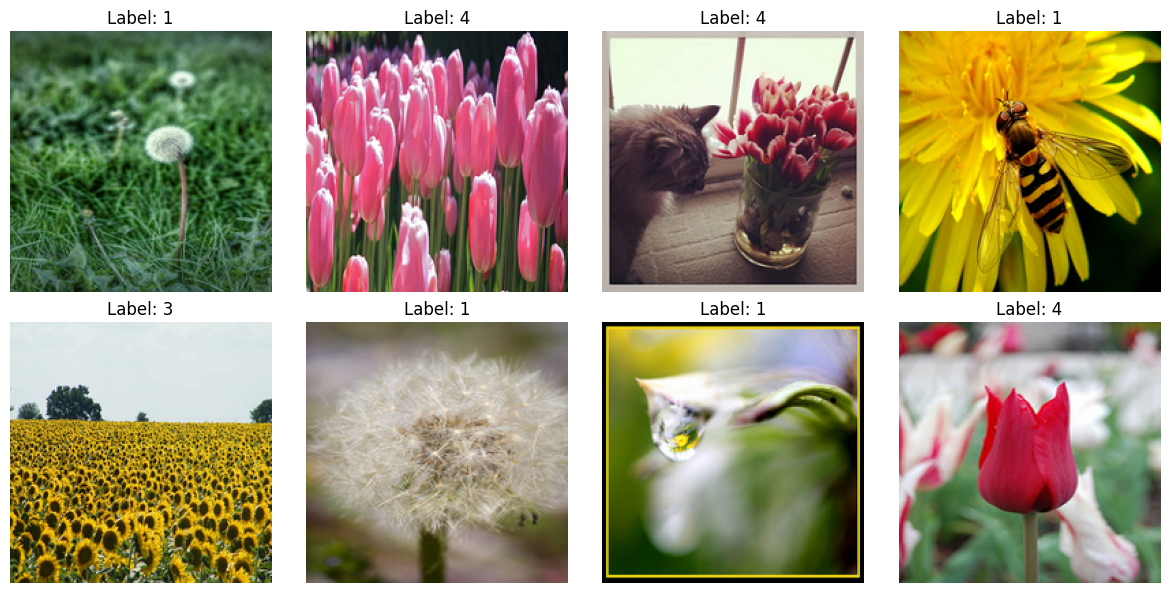

In [12]:
import matplotlib.pyplot as plt

img = X.permute(0, 2, 3, 1).numpy()

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.ravel()

for i in range(8):
    axs[i].imshow(img[i])
    axs[i].set_title(f"Label: {y[i].item()}")
    axs[i].axis('off')
plt.tight_layout()
plt.show()

### Maak augmentatie transforms

In [13]:
from torchvision import transforms

IMG_SIZE = 128

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE + 32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Test de transform op één image

In [14]:
x_single = X[0]
logger.info(f"Voor transform: {x_single.shape}")

x_transformed = train_transforms(x_single)
logger.info(f"Na transform: {x_transformed.shape}")

2025-12-29 13:16:56.233 | INFO     | __main__:<module>:2 - Voor transform: torch.Size([3, 192, 192])
2025-12-29 13:16:56.296 | INFO     | __main__:<module>:5 - Na transform: torch.Size([3, 128, 128])


### Maak de AugmentPreprocessor

In [15]:
class AugmentPreprocessor:
    def __init__(self, transform):
        self.transform = transform
    
    def __call__(self, batch):
        X, y = zip(*batch)
        X = [self.transform(x) for x in X]
        return torch.stack(X), torch.stack(y)

### Koppel preprocessors aan streamers

In [17]:
train.preprocessor = AugmentPreprocessor(train_transforms)
valid.preprocessor = AugmentPreprocessor(valid_transforms)

### Test met augmentatie

In [18]:
X_aug, y_aug = next(train.stream())
logger.info(f"Augmented X shape: {X_aug.shape}")
logger.info(f"Augmented y shape: {y_aug.shape}")

2025-12-29 15:00:14.465 | INFO     | __main__:<module>:2 - Augmented X shape: torch.Size([32, 3, 128, 128])
2025-12-29 15:00:14.474 | INFO     | __main__:<module>:3 - Augmented y shape: torch.Size([32])


### Visualiseer geaugmenteerde data

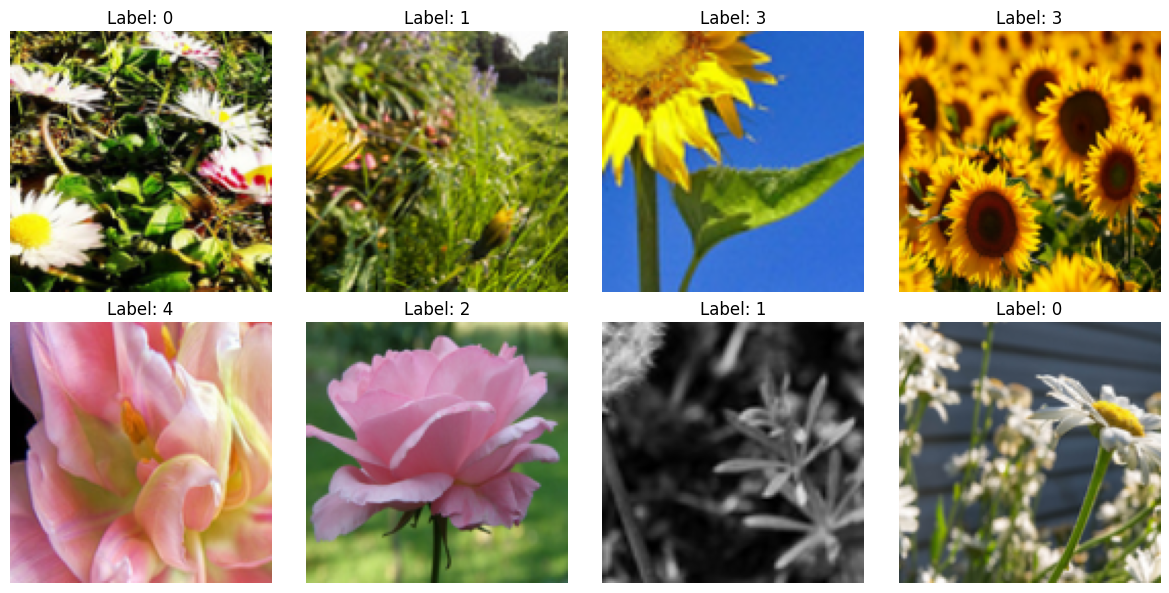

In [19]:
import numpy as np

img = X_aug.permute(0, 2, 3, 1).numpy()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = std * img + mean
img = np.clip(img, 0, 1)

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.ravel()
for i in range(8):
    axs[i].imshow(img[i])
    axs[i].set_title(f"Label: {y_aug[i].item()}")
    axs[i].axis("off")
plt.tight_layout()
plt.show()